# Single Shot Multibox Detection

We previously introduced bounding boxes, anchor boxes,
multiscale object detection, and the dataset for object detection.
Now we are ready to use such background
knowledge to design an object detection model:
[single shot multibox detection
(SSD)](https://arxiv.org/abs/1512.02325).
This model is simple, fast, and widely used.
Although this is just one of vast amounts of
object detection models,
some of the design principles
and implementation details in this section
are also applicable to other models.


## Model

The figure below provides an overview of
the design of single-shot multibox detection.
This model mainly consists of
a base network
followed by
several multiscale feature map blocks.
The base network
is for extracting features from the input image,
so it can use a deep CNN.
For example,
the [original single-shot multibox detection paper](https://arxiv.org/abs/1512.02325)
adopts a VGG network truncated before the
classification layer,
while ResNet has also been commonly used.
Through our design
we can make the base network output
larger feature maps
so as to generate more anchor boxes
for detecting smaller objects.
Subsequently,
each multiscale feature map block
reduces (e.g., by half)
the height and width of the feature maps
from the previous block,
and enables each unit
of the feature maps
to increase its receptive field on the input image.


Recall the design
of multiscale object detection
through layerwise representations of images by
deep neural networks
in [Part 3](./03-multiscale-object-detection-student.ipynb).
Since
multiscale feature maps (the ones closer to the top of the figure below)
are smaller but have larger receptive fields,
they are suitable for detecting
fewer but larger objects.

In a nutshell,
via its base network and several multiscale feature map blocks,
single-shot multibox detection
generates a varying number of anchor boxes with different sizes,
and detects varying-size objects
by predicting classes and offsets
of these anchor boxes (thus the bounding boxes);
thus, this is a multiscale object detection model.


![As a multiscale object detection model, single-shot multibox detection mainly consists of a base network followed by several multiscale feature map blocks.](https://raw.githubusercontent.com/d2l-ai/d2l-en/e4f0ed18d9d83cd35434404daaf7ffc9631b5ece/img/ssd.svg)


In the following,
we will describe the implementation details
of different blocks in the previous figure. To begin with, we discuss how to implement
the class and bounding box prediction.





### Class Prediction Layer

Let the number of object classes be $q$.
Then **anchor boxes have $q+1$ classes,
where class 0 is background**.
At some scale,
suppose that the height and width of feature maps
are $h$ and $w$, respectively.
When $a$ anchor boxes
are generated with
each spatial position of these feature maps as their center,
a total of $hwa$ anchor boxes need to be classified.
This often makes classification with fully connected layers infeasible due to likely
heavy parametrization costs.
Instead, it is common to use channels of
convolutional layers to predict classes.
Single-shot multibox detection uses the
same technique to reduce model complexity.

Specifically,
the class prediction layer uses a convolutional layer
without altering width or height of feature maps.
In this way,
there can be a one-to-one correspondence
between outputs and inputs
at the same spatial dimensions (width and height)
of feature maps.
More concretely,
channels of the output feature maps
at any spatial position ($x$, $y$)
represent class predictions
for all the anchor boxes centered on
($x$, $y$) of the input feature maps.
To produce valid predictions,
there must be **$a(q+1)$ output channels**,
where for the same spatial position
the output channel with index $i(q+1) + j$
represents the prediction of
the class $j$ ($0 \leq j \leq q$)
for the anchor box $i$ ($0 \leq i < a$).

Below we define such a class prediction layer,
specifying $a$ and $q$ via arguments `num_anchors` and `num_classes`, respectively.
This layer uses a $3\times3$ convolutional layer with a
padding of 1.
The width and height of the input and output of this
convolutional layer remain unchanged.


In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### Your turn
> Complete the code of the `cls_predictor` function below.
> 
> Return a simple `Conv2d` layer with the appropriate number of inputs and outputs.
>
> Use a `kernel_size` of 3 and set the `padding` to 1 to preserve image size.

In [ ]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(????)

In [2]:
# TEACHER
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

### **Bounding Box Prediction Layer**

The design of the bounding box prediction layer is similar to that of the class prediction layer.
The only difference lies in the number of outputs for each anchor box:
here we need to predict four offsets rather than $q+1$ classes.


### Your turn
> Complete the code of the `bbox_predictor` function below.
> 
> Return a simple `Conv2d` layer with the appropriate number of inputs and outputs.
>
> Use a `kernel_size` of 3 and set the `padding` to 1 to preserve image size.

In [ ]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(????)

In [3]:
# TEACHER
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

### Concatenating Predictions for Multiple Scales

As we mentioned, single-shot multibox detection
uses multiscale feature maps to generate anchor boxes and predict their classes and offsets.
At different scales,
the shapes of feature maps
or the numbers of anchor boxes centered on the same unit
may vary.
Therefore,
shapes of the prediction outputs
at different scales may vary.

In the following example,
we construct feature maps at two different scales,
`Y1` and `Y2`,
for the same minibatch,
where the height and width of `Y2`
are half of those of `Y1`.
Let's take class prediction as an example.
Suppose that
5 and 3 anchor boxes
are generated for every unit in `Y1` and `Y2`, respectively.
Suppose further that
the number of object classes is 10.
For feature maps `Y1` and `Y2`
the numbers of channels in the class prediction outputs
are $5\times(10+1)=55$ and $3\times(10+1)=33$, respectively,
where either output shape is
(batch size, number of channels, height, width).


In [4]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

As we can see, except for the batch size dimension,
the other three dimensions all have different sizes.
To concatenate these two prediction outputs for more efficient computation,
we will transform these tensors into a more consistent format.

Note that
the channel dimension holds the predictions for
anchor boxes with the same center.
We first move this dimension to the innermost (last).
Since the batch size remains the same for different scales,
we can transform the prediction output
into a two-dimensional tensor
with shape (batch size, height $\times$ width $\times$ number of channels).
Then we can concatenate
such outputs at different scales
along dimension 1.


In [5]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In this way,
even though `Y1` and `Y2` have different sizes
in channels, heights, and widths,
we can still concatenate these two prediction outputs at two different scales for the same minibatch.


In [6]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### Downsampling Block

In order to detect objects at multiple scales,
we define the following downsampling block `down_sample_blk` that
halves the height and width of input feature maps.
In fact,
this block applies the design of VGG blocks.
More concretely,
each downsampling block consists of
two $3\times3$ convolutional layers with padding of 1
followed by a $2\times2$ max-pooling layer with stride of 2.
As we know, $3\times3$ convolutional layers with padding of 1 do not change the shape of feature maps.
However, the subsequent $2\times2$ max-pooling  reduces the height and width of input feature maps by half.
For both input and output feature maps of this downsampling block,
because $1\times 2+(3-1)+(3-1)=6$,
each unit in the output
has a $6\times6$ receptive field on the input.
Therefore, the downsampling block enlarges the receptive field of each unit in its output feature maps.


### Your turn
> Complete the code of the `down_sample_blk` function below.
> 
> Configure the `Conv2d` and `MaxPool2d` layer according to the previous explanations.
>
> Use a `3×3` kernel for the convolution and preserve image size with appropriate padding.

In [ ]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(????))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(????))
    return nn.Sequential(*blk)

In [7]:
# TEACHER
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In the following example, our constructed downsampling block changes the number of input channels and halves the height and width of the input feature maps.


In [8]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### Base Network Block

The base network block is used to extract features from input images.
For simplicity,
we construct a small base network
consisting of three downsampling blocks
that double the number of channels at each block.
Given a $256\times256$ input image,
this base network block outputs $32 \times 32$ feature maps ($256/2^3=32$).


In [9]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### The Complete Model


**The complete
single shot multibox detection model
consists of five blocks.**
The feature maps produced by each block
are used for both
(i) generating anchor boxes
and (ii) predicting classes and offsets of these anchor boxes.
Among these five blocks,
the first one
is the base network block,
the second to the fourth are
downsampling blocks,
and the last block
uses global max-pooling
to reduce both the height and width to 1.
Technically,
the second to the fifth blocks
are all
those
multiscale feature map blocks
in the figure of the SSD architecture.


In [10]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

Now we **define the forward propagation**
for each block.
Different from
in image classification tasks,
outputs here include
(i) CNN feature maps `Y`,
(ii) anchor boxes generated using `Y` at the current scale,
and (iii) classes and offsets predicted (based on `Y`)
for these anchor boxes.


In [11]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

Recall that
in the figure of the SSD architecture,
a multiscale feature map block
that is closer to the top
is for detecting larger objects;
thus, it needs to generate larger anchor boxes.
In the above forward propagation,
at each multiscale feature map block
we pass in a list of two scale values
via the `sizes` argument
of the invoked `multibox_prior` function (described in [Part 2](./02-anchor-student.ipynb)).
In the following,
the interval between 0.2 and 1.05
is split evenly
into five sections to determine the
smaller scale values at the five blocks: 0.2, 0.37, 0.54, 0.71, and 0.88.
Then their larger scale values
are given by
$\sqrt{0.2 \times 0.37} = 0.272$, $\sqrt{0.37 \times 0.54} = 0.447$, and so on.

In [12]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

Now we can **define the complete model** `TinySSD` as follows.


In [13]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

We **create a model instance
and use it to perform forward propagation**
on a minibatch of $256 \times 256$ images `X`.

As shown earlier in this section,
the first block outputs $32 \times 32$ feature maps.
Recall that
the second to fourth downsampling blocks
halve the height and width
and the fifth block uses global pooling.
Since 4 anchor boxes
are generated for each unit along spatial dimensions
of feature maps,
at all the five scales
a total of $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$ anchor boxes are generated for each image.


In [14]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## Training

Now we will explain
how to train the single shot multibox detection model
for object detection.


### Reading the Dataset and Initializing the Model

To begin with,
let's **read
the banana detection dataset**
described in [Part 4](./04-object-detection-dataset-student.ipynb).


In [15]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


There is only one class in the banana detection dataset. After defining the model,
we need to (**initialize its parameters and define
the optimization algorithm**).


In [16]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

If you want, you can inspect the structure of the network by uncommenting the cell below.

In [ ]:
#net

In [17]:
# TEACHER
net

TinySSD(
  (blk_0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

We can get the total number of trainable parameters by counter the number of elements in each parameter:

In [18]:
sum(p.numel() for p in net.parameters() if p.requires_grad)

1010376

### **Defining Loss and Evaluation Functions**

Object detection has **two types of losses**.
The first loss concerns **classes of anchor boxes**:
its computation
can simply reuse
the **cross-entropy loss function**
that we use for image classification.
The second loss
concerns **offsets of positive (non-background) anchor boxes**:
this is a **regression problem**.
For this regression problem,
however,
here we do not use the squared loss
described.
Instead,
we **use the $\ell_1$ norm loss**,
the absolute value of the difference between
the prediction and the ground-truth.
The mask variable `bbox_masks` filters out
negative anchor boxes and illegal (padded)
anchor boxes in the loss calculation.
In the end, we sum up
the anchor box class loss
and the anchor box offset loss
to obtain the loss function for the model.


### Your turn
> Fix the definitions of the following loss functions to comply with the previous explanations.
>

In [ ]:
cls_loss = nn.????(reduction='none')
bbox_loss = nn.????(reduction='none')

In [19]:
# TEACHER
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

In [20]:

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

We can use accuracy to evaluate the classification results.
Due to the used $\ell_1$ norm loss for the offsets,
we use the *mean absolute error* to evaluate the
predicted bounding boxes.
These prediction results are obtained
from the generated anchor boxes and the
predicted offsets for them.


In [21]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

### **Training the Model**

When training the model,
we need to generate multiscale anchor boxes (`anchors`)
and predict their classes (`cls_preds`) and offsets (`bbox_preds`) in the forward propagation.
Then we label the classes (`cls_labels`) and offsets (`bbox_labels`) of such generated anchor boxes
based on the label information `Y`.
Finally, we calculate the loss function
using the predicted and labeled values
of the classes and offsets.
For concise implementations,
evaluation of the test dataset is omitted here.


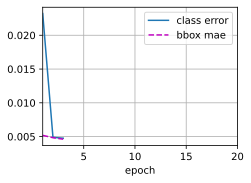

In [ ]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

## **Prediction**

During prediction,
the goal is to detect all the objects of interest
on the image.
Below
we read and resize a test image,
converting it to
a four-dimensional tensor that is
required by convolutional layers.


In [ ]:
!test -f banana.jpg || wget -O banana.jpg https://github.com/d2l-ai/d2l-en/blob/master/img/banana.jpg?raw=true
X = torchvision.io.read_image('banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()
d2l.plt.imshow(img)

Using the `multibox_detection` function below,
the predicted bounding boxes
are obtained
from the anchor boxes and their predicted offsets.
Then non-maximum suppression is used
to remove similar predicted bounding boxes.

Note that we need to apply a `softmax` layer on the class predictions to extract probabilities that we can feed into the `multibox_detection` function.

### Your turn
> Complete the code of the `predict()` function below to properly chain the output of the network to the `multibox_detection` function.

In [ ]:
def predict(X):
    net.eval()
    ????, ????, ???? = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(?????)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)
output[...,:10,:]

In [ ]:
# TEACHER
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)
output[...,:10,:]

Finally, we **display
all the predicted bounding boxes with
confidence 0.9 or above**
as output.


In [ ]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'r')

display(img, output.cpu(), threshold=0.3)

## Summary

* Single shot multibox detection is a multiscale object detection model. Via its base network and several multiscale feature map blocks, single-shot multibox detection generates a varying number of anchor boxes with different sizes, and detects varying-size objects by predicting classes and offsets of these anchor boxes (thus the bounding boxes).
* When training the single-shot multibox detection model, the loss function is calculated based on the predicted and labeled values of the anchor box classes and offsets.



## Improvements

Can you improve the single-shot multibox detection by improving the loss function? For example, replace $\ell_1$ norm loss with smooth $\ell_1$ norm loss for the predicted offsets. This loss function uses a square function around zero for smoothness, which is controlled by the hyperparameter $\sigma$:

$$
f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \textrm{if }|x| < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \textrm{otherwise}
    \end{cases}
$$

When $\sigma$ is very large, this loss is similar to the $\ell_1$ norm loss. When its value is smaller, the loss function is smoother.


In [ ]:
def smooth_l1(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar ** 2):
            out.append(((scalar * i) ** 2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar ** 2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = torch.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)
d2l.plt.legend();

Besides, in the experiment we used cross-entropy loss for class prediction:
denoting by $p_j$ the predicted probability for the ground-truth class $j$, the cross-entropy loss is $-\log p_j$. We can also use the [focal loss](https://openaccess.thecvf.com/content_iccv_2017/html/Lin_Focal_Loss_for_ICCV_2017_paper.html): given hyperparameters $\gamma > 0$
and $\alpha > 0$, this loss is defined as:

$$ - \alpha (1-p_j)^{\gamma} \log p_j.$$

As we can see, increasing $\gamma$
can effectively reduce the relative loss
for well-classified examples (e.g., $p_j > 0.5$)
so the training
can focus more on those difficult examples that are misclassified.


In [ ]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * torch.log(x)

x = torch.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)
d2l.plt.legend();